# **Assignment Roadmap**

This assignment asks you to build a complete Brain-Computer Interface (BCI) pipeline. Your goal is to take raw, noisy electrical brain signals and turn them into a clear Yes/No decision: Is this the character the user wants?

**Theres not much theory to learn other than implementation, you have to learn this by doing**

## AI Usage Policy for This Assignment

You're welcome to use AI for this assignment. Given the complexity of EEG signal processing and machine learning,
We don't expect you to know every implementation detail from scratch and neither does any recuiter or any professor.


Use AI to:

    Debug errors and troubleshoot issues

    Understand concepts and explore different approaches

What matters:

    You understand your code and can explain how it works

    You learn from the process, not just copy-paste

### **1: Cleaning the Signal (Preprocessing)**

The Goal: Raw EEG data is full of "garbage" frequencies like muscle movement and electrical hum. You need to filter the data to keep only the brain waves relevant to the P300 response (typically 0.1Hz – 20Hz).

You have already done this in the previous assignment but this one is a more standard procedure.

Common Pitfalls:

    Filter Lag: Standard filters can delay the signal, meaning the brain response looks like it happened later than it actually did. To prevent this, use zero-phase filtering (e.g., scipy.signal.filtfilt) instead of standard filtering (lfilter).

    Aliasing: You are asked to downsample the data from 240Hz to 60Hz to make it faster to process. Do not simply slice the array (e.g., data[::4]) without filtering first. If you do, high-frequency noise will "fold over" into your low frequencies and corrupt the data. Always filter before downsampling.

### **2: Epoch Extraction**

The Goal: You need to convert the continuous stream of data into specific "events" or "epochs."

The Concept: A P300 response happens roughly 300ms after a flash. Your code needs to identify every moment a flash occurs (stimulus_onset), look forward in time (e.g., 800ms), and "snip" that window of data out.

Visualizing the Data Structure:

    Input: A continuous 2D matrix (Total_Time_Points, 64_Channels)

    Output: A 3D block of events (Number_of_Flashes, Time_Points_Per_Window, 64_Channels)

Common Pitfall:

    Indexing Errors: This dataset may originate from MATLAB (which uses 1-based indexing), while Python uses 0-based indexing. If your index calculation is off by even one sample, your window will shift, and the machine learning model will be training on random noise rather than the brain response. Double-check your start and end indices.

### **3: Making Data "Model-Ready" (Feature Engineering)**

The Goal: Standard Machine Learning models (like SVM or LDA) cannot understand 3D arrays. They generally require a 2D matrix (like an Excel sheet). The Task:

    Time Domain: You will need to "flatten" the epochs. If an epoch is 60 time points × 64 channels, it becomes a single flat row of 3,840 numbers.

    PCA/CSP: These are compression techniques. The goal is to reduce those 3,840 numbers down to perhaps 20 numbers that capture the most important information.

Common Pitfall:

    Data Leakage: When using PCA or CSP, you must be careful not to "cheat." You should .fit() your reducer only on the training data, and then .transform() the test data. If you fit on the combined dataset, your model "sees" the test answers ahead of time, leading to artificially high scores that won't work in the real world.

### **4: Classification**

The Goal: Feed your features into the ML models (LDA, SVM, etc.) provided in the skeleton code to classify "Target" vs. "Non-Target" flashes.

Common Pitfall:

    Class Imbalance: In a P300 speller, the letter the user wants (Target) only flashes 1 out of 6 times. The other 5 flashes are Non-Targets.

        If your model decides to simply guess "Non-Target" every single time, it will still achieve ~83% accuracy. This is a useless model.

        Do not rely solely on Accuracy. Check the F1-Score or the Confusion Matrix. A good model must be able to correctly identify the rare Target events, not just the frequent Non-Targets.

In [ ]:
# The assignment is structured in a way that its modular so thats its easier to debug whats wrong

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import butter, filtfilt, iirnotch
from scipy.linalg import eigh
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix)
import pickle
import json
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
################################################################################
# SECTION 1: DATA LOADING AND BASIC SETUP
################################################################################

# Character matrix (6x6) for P300 speller
CHAR_MATRIX = np.array([
    ['A', 'B', 'C', 'D', 'E', 'F'],
    ['G', 'H', 'I', 'J', 'K', 'L'],
    ['M', 'N', 'O', 'P', 'Q', 'R'],
    ['S', 'T', 'U', 'V', 'W', 'X'],
    ['Y', 'Z', '1', '2', '3', '4'],
    ['5', '6', '7', '8', '9', '_']
])

def load_data(file_path):
    """
    Load P300 BCI Competition III data
    Returns dictionary with signal, flashing, stimulus_code, stimulus_type, target_char
    """

    mat = sio.loadmat(file_path)

    data = {
        'signal': mat['Signal'],                     # shape: (samples, channels)
        'flashing': mat['Flashing'].squeeze(),       # shape: (samples,)
        'stimulus_code': mat['StimulusCode'].squeeze()
    }

    # Training data has labels, test data doesn't
    if 'StimulusType' in mat:
        data['stimulus_type'] = mat['StimulusType'].squeeze()
    else:
        data['stimulus_type'] = None

    if 'TargetChar' in mat:
        data['target_char'] = mat['TargetChar'].squeeze().item()
    else:
        data['target_char'] = None


    return data


def get_char_from_codes(row_code, col_code):
    """Convert row/column stimulus codes to character"""
    """Stimulus codes convention:
        1–6 → rows
        7–12 → columns"""

    row_idx = row_code - 1
    col_idx = col_code - 7
    return CHAR_MATRIX[row_idx, col_idx]




In [ ]:
print(get_char_from_codes(1, 7))   # A
print(get_char_from_codes(6, 12))  # _


A
_


In [ ]:
# file_path = '/content/drive/MyDrive/Colab Notebooks/Winter_Projects 25-26/EEG_Speller/BCI_Comp_III_Wads_2004/Subject_A_Train.mat'

# mat = sio.loadmat(file_path)
# # mat.keys()
# print(mat['TargetChar'], end='\n')
# print(mat['StimulusCode'])

In [ ]:
################################################################################
# SECTION 2: EEG SIGNAL ACQUISITION & PREPROCESSING
################################################################################

def bandpass_filter(signal, lowcut=0.1, highcut=20, fs=240, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal, axis=0)



def notch_filter(signal, freq=50, fs=240, Q=30):
    """
    Remove powerline interference (50/60 Hz)
    """
    b, a = iirnotch(freq / (fs / 2), Q)
    return filtfilt(b, a, signal, axis=0)



def baseline_correction(epoch, baseline_samples=50):
    """
    Apply baseline correction by subtracting pre-stimulus baseline
    """
    baseline = np.mean(epoch[:baseline_samples, :], axis=0)
    return epoch - baseline



def downsample_signal(signal, original_fs=240, target_fs=60):
    """
    Downsample signal to reduce computational load
    240 Hz -> 60 Hz reduces data by 4x
    """
    factor = original_fs // target_fs
    return signal[::factor], target_fs



def artifact_rejection(signal, threshold=100):
    """
    Simple artifact rejection based on amplitude threshold
    More advanced: use ICA or wavelet denoising
    """
    # signal assumed in microvolts
    mask = np.max(np.abs(signal), axis=1) < threshold
    return signal[mask], mask



def preprocess_pipeline(data, apply_bandpass=True, apply_notch=True,
                       apply_downsample=True, fs=240):
    """
    Complete preprocessing pipeline:
    1. Bandpass filtering (0.1-20 Hz)
    2. Notch filtering (50 Hz)
    3. Downsampling (240->60 Hz)
    """
    signal = data['signal']

    if apply_bandpass:
        signal = bandpass_filter(signal, fs=fs)

    if apply_notch:
        signal = notch_filter(signal, fs=fs)

    if apply_downsample:
        signal, fs = downsample_signal(signal, fs, 60)

    data['signal'] = signal
    data['fs'] = fs
    return data


def extract_epochs(data, epoch_length_ms=800, fs=60, training=True):

    signal = data['signal']          # (85, T, 64)
    flashing = data['flashing']      # (85, T)
    stimulus_type = data.get('stimulus_type', None)

    epoch_samples = int(epoch_length_ms * fs / 1000)

    epochs = []
    labels = []
    codes_list = []
    char_idx_list = []

    n_chars, T, n_channels = signal.shape

    for char_idx in range(n_chars):

        flash = flashing[char_idx]
        eeg = signal[char_idx]

        onsets = np.where((flash[1:] == 1) & (flash[:-1] == 0))[0] + 1

        for onset in onsets:
            start = onset
            end = onset + epoch_samples
            if end >= T:
                continue

            epoch = eeg[start:end, :]

            baseline_samples = int(0.05 * fs)
            epoch = epoch - epoch[:baseline_samples].mean(axis=0)

            epochs.append(epoch)
            codes_list.append(data['stimulus_code'][char_idx, onset])
            char_idx_list.append(char_idx)

            if training:
                labels.append(int(stimulus_type[char_idx, onset] == 1))

    out = {
        'epochs': np.array(epochs),
        'codes': np.array(codes_list),
        'char_indices': np.array(char_idx_list)
    }

    if training:
        out['labels'] = np.array(labels, dtype=int)

    return out



def plot_erp_responses(epoch_data, channel_idx=31, fs=60):
    """
    Visualize ERP responses and confirm P300 peaks around 300ms
    Channel 31 = Cz (central midline electrode, best for P300)
    """
    epochs = epoch_data['epochs']
    labels = epoch_data['labels']

    target_epochs = epochs[labels == 1][:, :, channel_idx]
    nontarget_epochs = epochs[labels == 0][:, :, channel_idx]

    t = np.arange(target_epochs.shape[1]) / fs * 1000  # ms

    mean_t = target_epochs.mean(axis=0)
    mean_nt = nontarget_epochs.mean(axis=0)

    se_t = target_epochs.std(axis=0) / np.sqrt(target_epochs.shape[0])
    se_nt = nontarget_epochs.std(axis=0) / np.sqrt(nontarget_epochs.shape[0])

    plt.figure(figsize=(8, 4))
    plt.plot(t, mean_t, label='Target')
    plt.plot(t, mean_nt, label='Non-Target')
    plt.fill_between(t, mean_t-se_t, mean_t+se_t, alpha=0.3)
    plt.fill_between(t, mean_nt-se_nt, mean_nt+se_nt, alpha=0.3)

    plt.axvspan(250, 400, color='gray', alpha=0.2, label='P300 window')
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.title("ERP at Cz (Channel 31)")
    plt.show()

    print("P300 amplitude difference:",
          mean_t[300*fs//1000] - mean_nt[300*fs//1000])


Processed signal shape: (85, 7794, 64)
Epochs shape: (3938, 48, 64)
Labels distribution: [3283  655]


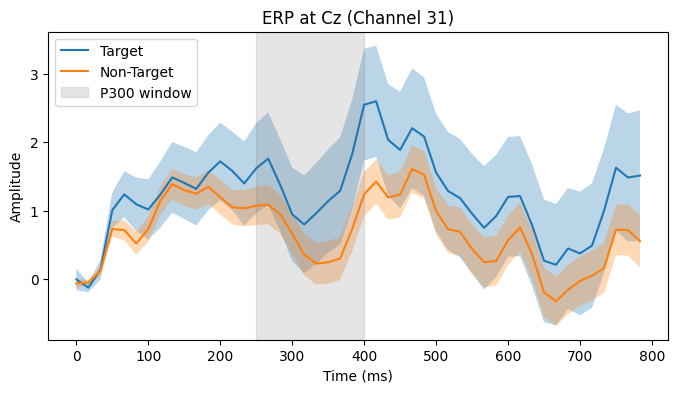

P300 amplitude difference: 0.2823305933264131
Processed signal shape: (22, 7794, 64)
Epochs shape: (3938, 48, 64)
Labels distribution: [3283  655]


In [ ]:
data_raw = load_data(
    '/content/drive/MyDrive/Colab Notebooks/Winter_Projects 25-26/EEG_Speller/BCI_Comp_III_Wads_2004/Subject_A_Train.mat'
)

# SAFE COPY (do not touch raw data)
data = {}
for k, v in data_raw.items():
    data[k] = v.copy() if isinstance(v, np.ndarray) else v


print("Processed signal shape:", data['signal'].shape)

data = preprocess_pipeline(
    data,
    apply_bandpass=True,
    apply_notch=True,
    apply_downsample=True,
    fs=240
)

epoch_data = extract_epochs(data)

print("Epochs shape:", epoch_data['epochs'].shape)
print("Labels distribution:", np.bincount(epoch_data['labels']))


# epoch_data = extract_epochs(
#     data,
#     epoch_length_ms=800,
#     fs=data['fs'],
#     runs_to_use=[0]   # ONLY first run
# )

# print(epoch_data['epochs'].shape)


# print(type(epoch_data['epochs']))
# print(epoch_data['epochs'].dtype)
# print(epoch_data['epochs'].shape)
# print(type(epoch_data['epochs'][0]))
# print(epoch_data['epochs'][0].shape)


plot_erp_responses(
    epoch_data,
    channel_idx=31,  # Cz
    fs=data['fs']
)

print("Processed signal shape:", data['signal'].shape)
print("Epochs shape:", epoch_data['epochs'].shape)
print("Labels distribution:", np.bincount(epoch_data['labels']))


In [ ]:
################################################################################
# SECTION 3: FEATURE ENGINEERING & BASELINE CLASSIFIERS
################################################################################

import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.linalg import eigh

# ---------------------------------------------------------------------
# 1. Time-domain features
# ---------------------------------------------------------------------
def extract_time_domain_features(epochs):
    n_epochs, n_samples, n_channels = epochs.shape
    return epochs.reshape(n_epochs, n_samples * n_channels)


# ---------------------------------------------------------------------
# 2. PCA features
# ---------------------------------------------------------------------
def extract_pca_features(epochs, n_components=20):
    X = extract_time_domain_features(epochs)
    pca = PCA(n_components=n_components, whiten=True, random_state=42)
    X_pca = pca.fit_transform(X)
    return X_pca, pca


# ---------------------------------------------------------------------
# 3. CSP features (binary)
# ---------------------------------------------------------------------
def extract_csp_features(epochs, labels, n_components=6):

    target_epochs = epochs[labels == 1]
    non_target_epochs = epochs[labels == 0]

    def compute_cov(data):
        covs = []
        for ep in data:
            ep = ep.T
            cov = ep @ ep.T
            cov /= np.trace(cov)
            covs.append(cov)
        return np.mean(covs, axis=0)

    cov_t = compute_cov(target_epochs)
    cov_nt = compute_cov(non_target_epochs)

    eigvals, eigvecs = eigh(cov_t, cov_t + cov_nt)
    idx = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, idx]

    W = np.hstack([
        eigvecs[:, :n_components // 2],
        eigvecs[:, -n_components // 2:]
    ])

    features = []
    for ep in epochs:
        Z = W.T @ ep.T
        var = np.var(Z, axis=1)
        features.append(np.log(var / np.sum(var)))

    return np.array(features), W


# ---------------------------------------------------------------------
# 4. Feature extraction wrapper
# ---------------------------------------------------------------------
def extract_features(epoch_data, method='pca', n_components=20):

    epochs = epoch_data['epochs']
    labels = epoch_data['labels']

    if method == 'time':
        X = extract_time_domain_features(epochs)
        return X, None

    elif method == 'pca':
        X, transformer = extract_pca_features(epochs, n_components)
        return X, transformer

    elif method == 'csp':
        X, transformer = extract_csp_features(epochs, labels, n_components)
        return X, transformer

    else:
        raise ValueError("Unknown feature method")


# ---------------------------------------------------------------------
# 5. Classifiers
# ---------------------------------------------------------------------
def train_lda_classifier(X_train, y_train):
    model = LinearDiscriminantAnalysis(priors=[0.5, 0.5])
    model.fit(X_train, y_train)
    return model


def train_logistic_regression(X_train, y_train):
    model = LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        solver='liblinear'
    )
    model.fit(X_train, y_train)
    return model


# ---------------------------------------------------------------------
# 6. Evaluation
# ---------------------------------------------------------------------
def evaluate_classifier(model, X_test, y_test, model_name="Model"):

    y_pred = model.predict(X_test)

    print(f"\n===== {model_name} =====")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


# ---------------------------------------------------------------------
# 7. RUN BASELINE EXPERIMENT
# ---------------------------------------------------------------------

# Choose feature type: 'time', 'pca', 'csp'
FEATURE_TYPE = 'pca'
N_COMPONENTS = 20

X, transformer = extract_features(epoch_data, FEATURE_TYPE, N_COMPONENTS)
y = epoch_data['labels']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

lda = train_lda_classifier(X_train, y_train)
evaluate_classifier(lda, X_test, y_test, "LDA")

logreg = train_logistic_regression(X_train, y_train)
evaluate_classifier(logreg, X_test, y_test, "Logistic Regression")



# ---------------------------------------------------------------------
# CSP Transformer Wrapper
# ---------------------------------------------------------------------
class CSPTransformer:
    """
    Wrapper for CSP spatial filters to provide transform() interface
    """

    def __init__(self, W):
        self.W = W  # CSP projection matrix (channels × components)

    def transform(self, epochs):
        """
        epochs: (n_epochs, n_samples, n_channels)
        returns: (n_epochs, n_components)
        """
        features = []

        for ep in epochs:
            Z = self.W.T @ ep.T            # (n_components, n_samples)
            var = np.var(Z, axis=1)
            features.append(np.log(var / np.sum(var)))

        return np.array(features)



===== LDA =====
Accuracy: 0.5350253807106599
Confusion Matrix:
 [[435 386]
 [ 72  92]]
              precision    recall  f1-score   support

           0       0.86      0.53      0.66       821
           1       0.19      0.56      0.29       164

    accuracy                           0.54       985
   macro avg       0.53      0.55      0.47       985
weighted avg       0.75      0.54      0.59       985


===== Logistic Regression =====
Accuracy: 0.5350253807106599
Confusion Matrix:
 [[434 387]
 [ 71  93]]
              precision    recall  f1-score   support

           0       0.86      0.53      0.65       821
           1       0.19      0.57      0.29       164

    accuracy                           0.54       985
   macro avg       0.53      0.55      0.47       985
weighted avg       0.75      0.54      0.59       985



In [ ]:
################################################################################
# SECTION 4: CLASSICAL MACHINE LEARNING MODELS
################################################################################

import numpy as np
import pickle
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# ---------------------------------------------------------------------
# 1. SVM
# ---------------------------------------------------------------------
def train_svm_classifier(X_train, y_train, kernel='rbf', C=1.0):
    model = SVC(
        kernel=kernel,
        C=C,
        class_weight='balanced',
        probability=True,
        random_state=42
    )
    model.fit(X_train, y_train)
    return model


# ---------------------------------------------------------------------
# 2. Random Forest
# ---------------------------------------------------------------------
def train_random_forest(X_train, y_train, n_estimators=100):
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    return model


# ---------------------------------------------------------------------
# 3. Gradient Boosting (manual class weights)
# ---------------------------------------------------------------------
def train_gradient_boosting(X_train, y_train, n_estimators=100):
    print(f"\n  Training Gradient Boosting (n_estimators={n_estimators})...")

    classes, counts = np.unique(y_train, return_counts=True)
    total = len(y_train)
    class_weights = {c: total / (2 * cnt) for c, cnt in zip(classes, counts)}
    sample_weights = np.array([class_weights[y] for y in y_train])

    model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        random_state=42
    )
    model.fit(X_train, y_train, sample_weight=sample_weights)
    return model


# ---------------------------------------------------------------------
# 4. Compare all classical models
# ---------------------------------------------------------------------
def compare_all_classical_models(X_train, y_train, X_test, y_test):

    print("\n================ MODEL COMPARISON ================\n")

    models = {
        "SVM (RBF)": lambda: train_svm_classifier(X_train, y_train),
        "Random Forest": lambda: train_random_forest(X_train, y_train),
        "Gradient Boosting": lambda: train_gradient_boosting(X_train, y_train)
    }

    results = {}

    for name, train_fn in models.items():

        print(f"\n----- {name} -----")
        model = train_fn()

        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        results[name] = acc

        print("Accuracy:", acc)
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))

    print("\n=============== SUMMARY ===============")
    for k, v in results.items():
        print(f"{k:20s}: {v:.4f}")

    return results


# ---------------------------------------------------------------------
# 5. Save / Load utilities
# ---------------------------------------------------------------------
def save_model(model, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"\n  Model saved to: {filepath}")


def load_model(filepath):
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    print(f"\n  Model loaded from: {filepath}")
    return model


# ---------------------------------------------------------------------
# 6. RUN EXPERIMENT
# ---------------------------------------------------------------------

# Reuse features from Section 3
# FEATURE_TYPE = 'pca' or 'csp' recommended
FEATURE_TYPE = 'pca'
N_COMPONENTS = 20

X, _ = extract_features(epoch_data, FEATURE_TYPE, N_COMPONENTS)
y = epoch_data['labels']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

results = compare_all_classical_models(
    X_train, y_train,
    X_test, y_test
)



================ MODEL COMPARISON ================


----- SVM (RBF) -----
Accuracy: 0.5431472081218274
Confusion Matrix:
 [[460 361]
 [ 89  75]]
              precision    recall  f1-score   support

           0       0.84      0.56      0.67       821
           1       0.17      0.46      0.25       164

    accuracy                           0.54       985
   macro avg       0.50      0.51      0.46       985
weighted avg       0.73      0.54      0.60       985


----- Random Forest -----
Accuracy: 0.8355329949238579
Confusion Matrix:
 [[821   0]
 [162   2]]
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       821
           1       1.00      0.01      0.02       164

    accuracy                           0.84       985
   macro avg       0.92      0.51      0.47       985
weighted avg       0.86      0.84      0.76       985


----- Gradient Boosting -----

  Training Gradient Boosting (n_estimators=100)...
Accuracy: 0.614213

In [ ]:
    # ========================================================================
    # STEP 1: LOAD DATA
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 1: LOADING DATA")
    print("="*70)

    from google.colab import drive

    drive.mount('/content/drive')
    DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/Winter_Projects 25-26/EEG_Speller/BCI_Comp_III_Wads_2004/'

    train_data_A = load_data(DATA_PATH + 'Subject_A_Train.mat')
    test_data_A = load_data(DATA_PATH + 'Subject_A_Test.mat')
    train_data_B = load_data(DATA_PATH + 'Subject_B_Train.mat')
    test_data_B = load_data(DATA_PATH + 'Subject_B_Test.mat')



STEP 1: LOADING DATA
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
    # ========================================================================
    # STEP 2: PREPROCESSING
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 2: PREPROCESSING")
    print("="*70)

    print("\n--- Subject A ---")
    train_proc_A = preprocess_pipeline(train_data_A)
    test_proc_A = preprocess_pipeline(test_data_A)

    print("\n--- Subject B ---")
    train_proc_B = preprocess_pipeline(train_data_B)
    test_proc_B = preprocess_pipeline(test_data_B)



STEP 2: PREPROCESSING

--- Subject A ---

--- Subject B ---


In [ ]:
    # ========================================================================
    # STEP 3: EPOCH EXTRACTION
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 3: EPOCH EXTRACTION")
    print("="*70)

    # Subject A
    train_epochs_A = extract_epochs(train_proc_A, training=True)
    test_epochs_A  = extract_epochs(test_proc_A, training=False)

    # Subject B
    train_epochs_B = extract_epochs(train_proc_B, training=True)
    test_epochs_B  = extract_epochs(test_proc_B, training=False)



STEP 3: EPOCH EXTRACTION



STEP 4: VISUALIZING ERP RESPONSES

--- Subject A ---


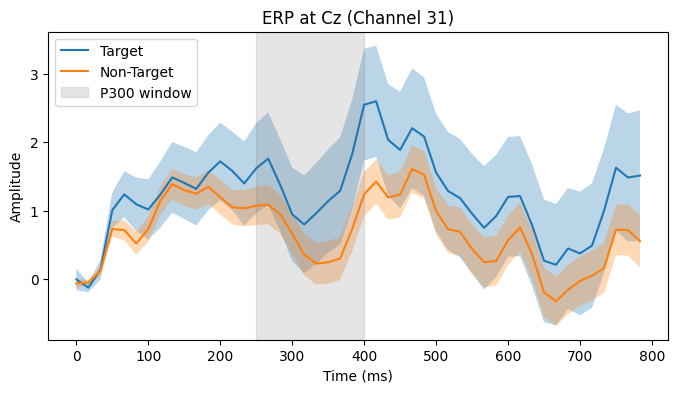

P300 amplitude difference: 0.2823305933264131


In [ ]:
    # ========================================================================
    # STEP 4: VISUALIZE ERP
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 4: VISUALIZING ERP RESPONSES")
    print("="*70)

    print("\n--- Subject A ---")
    plot_erp_responses(train_epochs_A, channel_idx=31)

In [ ]:
################################################################################
# STEP 5: FEATURE EXTRACTION & COMPARISON
################################################################################

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC

print("\n" + "="*70)
print("STEP 5: FEATURE EXTRACTION")
print("="*70)

# ---------------------------------------------------------------------
# Helper: evaluate features with balanced classifier
# ---------------------------------------------------------------------
def evaluate_features(X, y, model_type='lda'):
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    if model_type == 'lda':
        model = LinearDiscriminantAnalysis(priors=[0.5, 0.5])
    else:
        model = LinearSVC(class_weight='balanced', max_iter=5000)

    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    return accuracy_score(y_te, y_pred), f1_score(y_te, y_pred)


# =====================================================================
# SUBJECT A: FEATURE COMPARISON
# =====================================================================
print("\n--- Subject A: Feature Comparison ---")

epochs_A = train_epochs_A['epochs']
labels_A = train_epochs_A['labels']

# ---------------- PCA (20) ----------------
X_pca20_A, pca20_A = extract_features(train_epochs_A, method='pca', n_components=20)
acc_pca20, f1_pca20 = evaluate_features(X_pca20_A, labels_A)

# ---------------- PCA (50) ----------------
X_pca50_A, pca50_A = extract_features(train_epochs_A, method='pca', n_components=50)
acc_pca50, f1_pca50 = evaluate_features(X_pca50_A, labels_A)

# ---------------- CSP (6) ----------------
X_csp_A, W_csp_A = extract_features(train_epochs_A, method='csp', n_components=6)
acc_csp, f1_csp = evaluate_features(X_csp_A, labels_A)

# ---------------- Time-domain ----------------
X_time_A = epochs_A.reshape(len(epochs_A), -1)
acc_time, f1_time = evaluate_features(X_time_A, labels_A, model_type='svm')


print("\n" + "="*70)
print("FEATURE COMPARISON (Balanced Classifiers)")
print("="*70)
print(f"PCA (20 comp):      Accuracy={acc_pca20:.4f}, F1={f1_pca20:.4f}")
print(f"PCA (50 comp):      Accuracy={acc_pca50:.4f}, F1={f1_pca50:.4f}")
print(f"CSP (6 comp):       Accuracy={acc_csp:.4f}, F1={f1_csp:.4f}")
print(f"Time-Domain:        Accuracy={acc_time:.4f}, F1={f1_time:.4f}")


# =====================================================================
# SELECT BEST FEATURE METHOD (BASED ON F1)
# =====================================================================
scores = {
    'pca20': f1_pca20,
    'pca50': f1_pca50,
    'csp': f1_csp,
    'time': f1_time
}

best_key = max(scores, key=scores.get)
print("\nSelected feature method for Subject A:", best_key)

if best_key == 'pca20':
    feature_method_A = 'pca'
    feature_obj_A = pca20_A
    n_components_A = 20
    X_train_full_A = X_pca20_A

elif best_key == 'pca50':
    feature_method_A = 'pca'
    feature_obj_A = pca50_A
    n_components_A = 50
    X_train_full_A = X_pca50_A

elif best_key == 'csp':
    feature_method_A = 'csp'
    feature_obj_A = W_csp_A
    n_components_A = 6
    X_train_full_A = X_csp_A

else:
    feature_method_A = 'time'
    feature_obj_A = None
    X_train_full_A = X_time_A


# =====================================================================
# SUBJECT A: FINAL TRAIN / VAL SPLIT
# =====================================================================
X_train_A, X_val_A, y_train_A, y_val_A = train_test_split(
    X_train_full_A,
    train_epochs_A['labels'],
    test_size=0.2,
    random_state=42,
    stratify=train_epochs_A['labels']
)

print(f"\nSubject A splits: Training={len(X_train_A)}, Validation={len(X_val_A)}")

# Transform TEST data (Subject A)
if feature_method_A == 'time':
    X_test_A = test_epochs_A['epochs'].reshape(len(test_epochs_A['epochs']), -1)

elif feature_method_A == 'pca':
    X_test_A = feature_obj_A.transform(
        test_epochs_A['epochs'].reshape(len(test_epochs_A['epochs']), -1)
    )

else:  # CSP
    X_test_A = CSPTransformer(feature_obj_A).transform(test_epochs_A['epochs'])

print(f"Subject A test features: {X_test_A.shape}")


# =====================================================================
# SUBJECT B: USE SAME FEATURE METHOD
# =====================================================================
print("\n--- Subject B: Feature Extraction ---")
print(f"Using {feature_method_A.upper()} (same as Subject A)")

if feature_method_A == 'time':
    X_train_full_B = train_epochs_B['epochs'].reshape(len(train_epochs_B['epochs']), -1)
    X_test_B = test_epochs_B['epochs'].reshape(len(test_epochs_B['epochs']), -1)

elif feature_method_A == 'pca':
    X_train_full_B, pca_B = extract_features(
        train_epochs_B, method='pca', n_components=n_components_A
    )
    X_test_B = pca_B.transform(
        test_epochs_B['epochs'].reshape(len(test_epochs_B['epochs']), -1)
    )

else:  # CSP
    X_train_full_B, W_csp_B = extract_features(
        train_epochs_B, method='csp', n_components=6
    )
    X_test_B = CSPTransformer(W_csp_B).transform(test_epochs_B['epochs'])

X_train_B, X_val_B, y_train_B, y_val_B = train_test_split(
    X_train_full_B,
    train_epochs_B['labels'],
    test_size=0.2,
    random_state=42,
    stratify=train_epochs_B['labels']
)

print(f"Subject B splits: Training={len(X_train_B)}, Validation={len(X_val_B)}")
print(f"Subject B test features: {X_test_B.shape}")



STEP 5: FEATURE EXTRACTION

--- Subject A: Feature Comparison ---

FEATURE COMPARISON (Balanced Classifiers)
PCA (20 comp):      Accuracy=0.5350, F1=0.2866
PCA (50 comp):      Accuracy=0.5218, F1=0.2440
CSP (6 comp):       Accuracy=0.6030, F1=0.3429
Time-Domain:        Accuracy=0.6843, F1=0.1751

Selected feature method for Subject A: csp

Subject A splits: Training=3150, Validation=788
Subject A test features: (4475, 6)

--- Subject B: Feature Extraction ---
Using CSP (same as Subject A)
Subject B splits: Training=3150, Validation=788
Subject B test features: (4475, 6)


In [ ]:
################################################################################
# STEP 6: BASELINE CLASSIFIERS
################################################################################

from sklearn.metrics import accuracy_score, f1_score

print("\n" + "="*70)
print("STEP 6: BASELINE CLASSIFIERS (Subject A)")
print("="*70)

# ---------------------------------------------------------------------
# Modified evaluator that RETURNS metrics
# ---------------------------------------------------------------------
def evaluate_classifier_return(model, X_test, y_test, model_name="Model"):

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n===== {model_name} =====")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")

    return acc, f1


# ---------------- LDA ----------------
lda_A = train_lda_classifier(X_train_A, y_train_A)
acc_lda, f1_lda = evaluate_classifier_return(
    lda_A, X_val_A, y_val_A, "LDA"
)

# ---------------- Logistic Regression ----------------
lr_A = train_logistic_regression(X_train_A, y_train_A)
acc_lr, f1_lr = evaluate_classifier_return(
    lr_A, X_val_A, y_val_A, "Logistic Regression"
)

print("\n" + "="*70)
print("BASELINE CLASSIFIER SUMMARY (Subject A)")
print("="*70)
print(f"LDA:                Accuracy={acc_lda:.4f}, F1={f1_lda:.4f}")
print(f"Logistic Regression Accuracy={acc_lr:.4f}, F1={f1_lr:.4f}")



STEP 6: BASELINE CLASSIFIERS (Subject A)

===== LDA =====
Accuracy: 0.6015
F1-score: 0.3458

===== Logistic Regression =====
Accuracy: 0.5838
F1-score: 0.3279

BASELINE CLASSIFIER SUMMARY (Subject A)
LDA:                Accuracy=0.6015, F1=0.3458
Logistic Regression Accuracy=0.5838, F1=0.3279


In [ ]:
def train_svm_classifier(X_train, y_train, kernel='rbf', C=1.0):
    model = SVC(
        kernel=kernel,
        C=C,
        class_weight='balanced',
        probability=True,
        random_state=42
    )
    model.fit(X_train, y_train)
    return model



def compare_all_classical_models(X_train, y_train, X_test, y_test):

    print("\n================ MODEL COMPARISON ================\n")

    model_builders = {
        "SVM (RBF)": lambda: train_svm_classifier(X_train, y_train),
        "Random Forest": lambda: train_random_forest(X_train, y_train),
        "Gradient Boosting": lambda: train_gradient_boosting(X_train, y_train)
    }

    results = {}
    models = {}

    for name, build_fn in model_builders.items():

        print(f"\n----- {name} -----")
        model = build_fn()
        models[name] = model

        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results[name] = acc

        print("Accuracy:", acc)
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))

    print("\n=============== SUMMARY ===============")
    for k, v in results.items():
        print(f"{k:20s}: {v:.4f}")

    return results, models
################################################################################
# STEP 7: CLASSICAL MACHINE LEARNING MODELS
################################################################################

print("\n" + "="*70)
print("STEP 7: CLASSICAL MACHINE LEARNING (Subject A)")
print("="*70)

results_classical_A, models_A = compare_all_classical_models(
    X_train_A, y_train_A, X_val_A, y_val_A
)

# ---------------------------------------------------------------------
# Train final SVM models (for decoding / export)
# ---------------------------------------------------------------------
svm_A = train_svm_classifier(X_train_A, y_train_A)
svm_B = train_svm_classifier(X_train_B, y_train_B)



STEP 7: CLASSICAL MACHINE LEARNING (Subject A)

================ MODEL COMPARISON ================


----- SVM (RBF) -----
Accuracy: 0.5456852791878173
Confusion Matrix:
 [[347 310]
 [ 48  83]]
              precision    recall  f1-score   support

           0       0.88      0.53      0.66       657
           1       0.21      0.63      0.32       131

    accuracy                           0.55       788
   macro avg       0.54      0.58      0.49       788
weighted avg       0.77      0.55      0.60       788


----- Random Forest -----
Accuracy: 0.8324873096446701
Confusion Matrix:
 [[653   4]
 [128   3]]
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       657
           1       0.43      0.02      0.04       131

    accuracy                           0.83       788
   macro avg       0.63      0.51      0.48       788
weighted avg       0.77      0.83      0.76       788


----- Gradient Boosting -----

  Training Gradient B

In [ ]:
################################################################################
# STEP 8: EXPORT MODELS
################################################################################

print("\n" + "="*70)
print("STEP 8: EXPORTING MODELS")
print("="*70)

import os
os.makedirs('models', exist_ok=True)

# ---------------- Subject A ----------------
save_model({
    'classifier': lda_A,
    'feature_method': feature_method_A,
    'feature_object': feature_obj_A,
    'n_components': n_components_A if feature_method_A != 'time' else None
}, 'models/subject_A_lda.pkl')


# ---------------- Subject B ----------------
lda_B = train_lda_classifier(X_train_B, y_train_B)

save_model({
    'classifier': lda_B,
    'feature_method': feature_method_A,
    'feature_object': feature_obj_A if feature_method_A != 'csp' else None,
    'n_components': n_components_A if feature_method_A != 'time' else None
}, 'models/subject_B_lda.pkl')



STEP 8: EXPORTING MODELS

  Model saved to: models/subject_A_lda.pkl

  Model saved to: models/subject_B_lda.pkl


In [ ]:
print("Total epochs:", len(epoch_data['labels']))
print("Class counts:", np.unique(epoch_data['labels'], return_counts=True))


Total epochs: 3938
Class counts: (array([0, 1]), array([3283,  655]))
